In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def preprocess_data(vocab_size=10000, maxlen=200):
    """
    Loads and preprocesses the IMDb dataset for binary text classification.
    Returns padded sequences and labels for training and testing.
    """
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
    
    # Pad sequences to fixed length for uniform input size
    x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
    x_test = pad_sequences(x_test, maxlen=maxlen, padding='post')
    
    return x_train, y_train, x_test, y_test, vocab_size, maxlen

In [3]:
x_train, y_train, x_test, y_test, vocab_size, maxlen = preprocess_data()

In [4]:
# Load IMDB dataset
(x_train_raw, y_train), (x_test_raw, y_test) = imdb.load_data(num_words=vocab_size)

# Word index for decoding
word_index = imdb.get_word_index()
reverse_word_index = {value + 3: key for key, value in word_index.items()}
reverse_word_index[0] = "[PAD]"
reverse_word_index[1] = "[START]"
reverse_word_index[2] = "[UNK]"
reverse_word_index[3] = "[UNUSED]"

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [5]:
for i in range(3):
    print(f"\nReview #{i+1}")
    print(decode_review(x_train_raw[i+2]))
    print("Label:", "Positive" if y_train[i] == 1 else "Negative")
    print("-" * 100)



Review #1
[START] this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had [UNK] working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how [UNK] this is to watch save yourself an hour a bit of your life
Label: Positive
----------------------------------------------------------------------------------------------------

Review #2
[START] the [UNK] [UNK] at storytelling the traditional sort many years after the event i can still see in my [UNK] eye an elderly lady my friend's mother retel

In [6]:
x_train = pad_sequences(x_train_raw, maxlen=maxlen)
x_test = pad_sequences(x_test_raw, maxlen=maxlen)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Custom self-attention layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        u_it = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_it = tf.nn.softmax(tf.tensordot(u_it, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * a_it, axis=1)
        return output

# Model definition
input_layer = Input(shape=(maxlen,))
x = Embedding(input_dim=vocab_size, output_dim=256, input_length=maxlen)(input_layer)

x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = SelfAttention()(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 256)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         164352    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 200, 128)         512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 64)          41216 

In [8]:


# 4. Define callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [9]:
# 5. Train the model
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)

Epoch 1/20
157/157 - 19s - loss: 1.4935 - accuracy: 0.6427 - val_loss: 1.4096 - val_accuracy: 0.4938 - lr: 1.0000e-04 - 19s/epoch - 119ms/step
Epoch 2/20
157/157 - 12s - loss: 1.1148 - accuracy: 0.8069 - val_loss: 1.2186 - val_accuracy: 0.8034 - lr: 1.0000e-04 - 12s/epoch - 76ms/step
Epoch 3/20
157/157 - 12s - loss: 0.9052 - accuracy: 0.8708 - val_loss: 0.9148 - val_accuracy: 0.8656 - lr: 1.0000e-04 - 12s/epoch - 76ms/step
Epoch 4/20
157/157 - 12s - loss: 0.7660 - accuracy: 0.9090 - val_loss: 0.9830 - val_accuracy: 0.8160 - lr: 1.0000e-04 - 12s/epoch - 76ms/step
Epoch 5/20
157/157 - 11s - loss: 0.6700 - accuracy: 0.9280 - val_loss: 0.8554 - val_accuracy: 0.8630 - lr: 1.0000e-04 - 11s/epoch - 72ms/step
Epoch 6/20
157/157 - 11s - loss: 0.6027 - accuracy: 0.9409 - val_loss: 0.9860 - val_accuracy: 0.8362 - lr: 1.0000e-04 - 11s/epoch - 71ms/step
Epoch 7/20
157/157 - 11s - loss: 0.5364 - accuracy: 0.9610 - val_loss: 0.8420 - val_accuracy: 0.8756 - lr: 5.0000e-05 - 11s/epoch - 71ms/step
Epoch

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

782/782 [==============================] - 19s 23ms/step
              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86     12500
    Positive       0.87      0.84      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



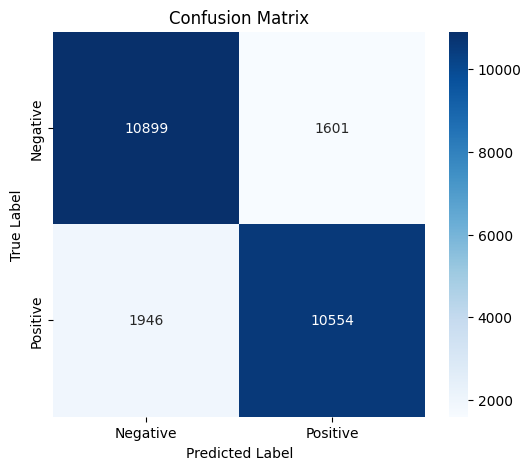

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


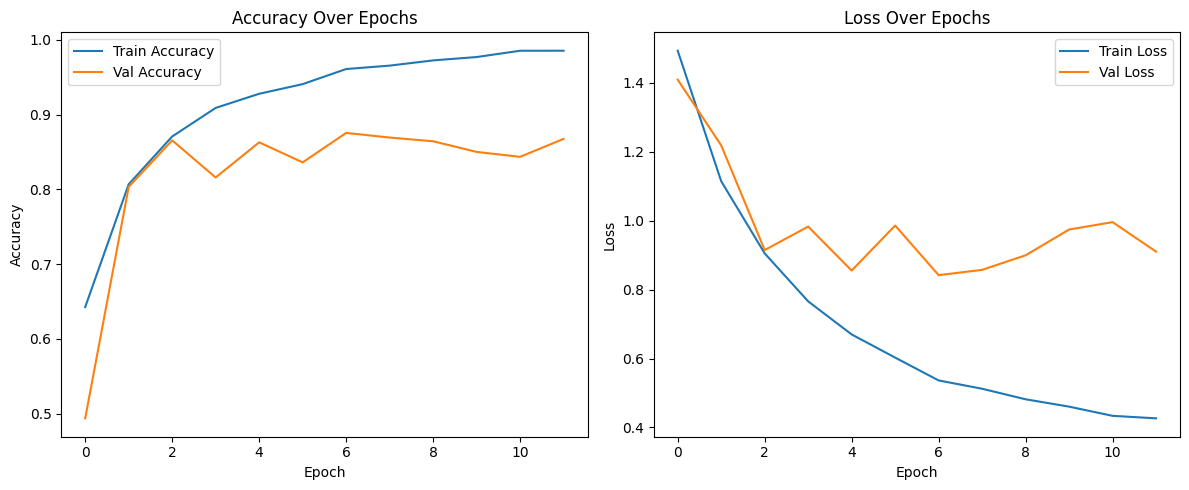

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Load the word index from IMDb dataset
word_index = imdb.get_word_index()
reverse_word_index = {value + 3: key for key, value in word_index.items()}
reverse_word_index[0] = "[PAD]"
reverse_word_index[1] = "[START]"
reverse_word_index[2] = "[UNK]"
reverse_word_index[3] = "[UNUSED]"

# Function to decode review properly
def decode_review(sequence):
    words = [reverse_word_index.get(i, '?') for i in sequence if i > 3]
    return ' '.join(words)


In [14]:
import random

# Pick a random test index
idx = random.randint(0, len(x_test) - 1)

# Predict the label for this review
pred = model.predict(np.expand_dims(x_test[idx], axis=0), verbose=0)[0][0]
pred_label = "Positive" if pred > 0.5 else "Negative"

# Print decoded review and results
print("Review:")
print(decode_review(x_test[idx]))
print("\nTrue Label:", "Positive" if y_test[idx] else "Negative")
print("Predicted Label:", pred_label)


Review:
lucio don't torture a paints an exceptionally portrait of small town plagued by series of brutal murders of young boys this surprisingly well directed film especially in comparison to later is distinguished by overall atmosphere of and two truly grotesque scenes of brutal violence the soon to be dead children are depicted as casually cruel and budding near seduction by the naked barbara really has to be seen to be believed highly recommended especially in pair with my another cult favourite house with the windows that laugh 1976

True Label: Positive
Predicted Label: Positive
